In [1]:
import numpy as np
import pandas as pd
import os
import sys
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

path = r"C:\Users\user\Victor\Trabajo\NoEstacionario\Python"
os.chdir(path)
os.getcwd()

'C:\\Users\\user\\Victor\\Trabajo\\NoEstacionario\\Python'

In [2]:
data = pd.read_table("Datos\\Hs_SS_PCs_FWT_LWT_Precip_Cantabria_reg_guided.txt")
# data = pd.read_table("Datos\\Hs_SS_PCs_RWT_LWT_Precip_Cantabria.txt")
# data.rename(columns={'RWT':'FWT'}, inplace=True)

In [3]:
# Columns for the Hs dataframe
cols_first = ['yyyy', 'mm', 'dd', 'Hs'] + [col for col in data.columns if col.startswith('PC') and not col.endswith('_SS')] + ['FWT']

# Columns for the Surge dataframe
cols_second = ['yyyy', 'mm', 'dd', 'Surge'] + [col for col in data.columns if col.endswith('_SS')] + ['LWT']
# Columns for the precipitation data
cols_third = ['yyyy', 'mm', 'dd', 'precip', 'LWT']

# Create the two DataFrames
df_hs = data[cols_first]
df_surge = data[cols_second]
df_prec = data[cols_third]

In [4]:
# Define the days in a month dictionary
days_in_month = {1: 31, 2: 28.25, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}

# Correct the time assignment for df_hs
df_hs = df_hs.copy()  # Ensure it's a copy, avoiding modifying the original DataFrame slice
df_hs['time'] = (
    df_hs['yyyy'] - np.min(df_hs['yyyy'])
    + (df_hs['mm'] - 1) / 12
    + df_hs['dd'] / df_hs['mm'].map(days_in_month) / 12
)

# Correct the time assignment for df_surge
df_surge = df_surge.copy()  # Ensure it's a copy, avoiding modifying the original DataFrame slice
df_surge['time'] = (
    df_surge['yyyy'] - np.min(df_surge['yyyy'])
    + (df_surge['mm'] - 1) / 12
    + df_surge['dd'] / df_surge['mm'].map(days_in_month) / 12
)

df_prec = df_prec.copy()  # Ensure it's a copy, avoiding modifying the original DataFrame slice
df_prec['time'] = (
    df_prec['yyyy'] - np.min(df_prec['yyyy'])
    + (df_prec['mm'] - 1) / 12
    + df_prec['dd'] / df_prec['mm'].map(days_in_month) / 12
)

# Análisis para Precipitación por WT

In [5]:
wt_probs = df_prec['LWT'].value_counts(normalize=True).sort_index()
wt_range = np.sort(df_prec['LWT'].unique())

Diccionario con un DataFrame asociado a cada WT distinto.

In [6]:
dict_hs = {}
for idx_wt, wt in enumerate(wt_range):
    dict_hs[idx_wt] = df_prec[:][df_prec['LWT'] == idx_wt]

In [7]:
# Yearly maxima
hsmax_data = {}
max_idx = {}

for idx_wt, wt in enumerate(wt_range):
    hsmax_data[idx_wt] = dict_hs[idx_wt].groupby(["yyyy"], as_index=False)["precip"].max()  # Máximo anual Hs para cada WT
    max_idx[idx_wt] = dict_hs[idx_wt].groupby(["yyyy"])["precip"].idxmax().values           # Indice del máximo anual por WT
n_return_period = 365.25

In [8]:
n_return_period = 365.25*wt_probs

Datos ordenados

In [9]:
hsmax_data_sorted = {}
sorted_max_idx = {}
for idx_wt, wt in enumerate(wt_range):
    hsmax_data_sorted[idx_wt] = np.sort(hsmax_data[idx_wt]['precip'])
    sorted_max_idx[idx_wt] = np.argsort(hsmax_data[idx_wt]['precip'])

Point-in-time data

In [10]:
hspt = {}
hspt_sort = {}
# Hs point-in-time data per WT
for idx_wt, wt in enumerate(wt_range):
    hspt[idx_wt] = dict_hs[idx_wt]['precip'].values
    hspt_sort[idx_wt] = np.sort(dict_hs[idx_wt]['precip'].values)

Cálculo de las ECDF y el periodo de retorno para cada WT

In [11]:
ecdf_pt_probs= {}
T_pt = {}
ecdf_ev_probs_wt = {}
T_ev_wt = {}

for idx_wt, wt in enumerate(wt_range):
    # Empirical df and Return period for point in time
    ecdf_pt_probs[idx_wt] = np.arange(1,len(hspt[idx_wt])+1)/(len(hspt[idx_wt])+1)
    T_pt[idx_wt] = 1/(1-ecdf_pt_probs[idx_wt])/n_return_period[idx_wt]

    # Empirical df and Return period for monthly maxima
    ecdf_ev_probs_wt[idx_wt] = np.arange(1,len(hsmax_data[idx_wt])+1)/(len(hsmax_data[idx_wt])+1)
    T_ev_wt[idx_wt] = 1/(1-ecdf_ev_probs_wt[idx_wt])

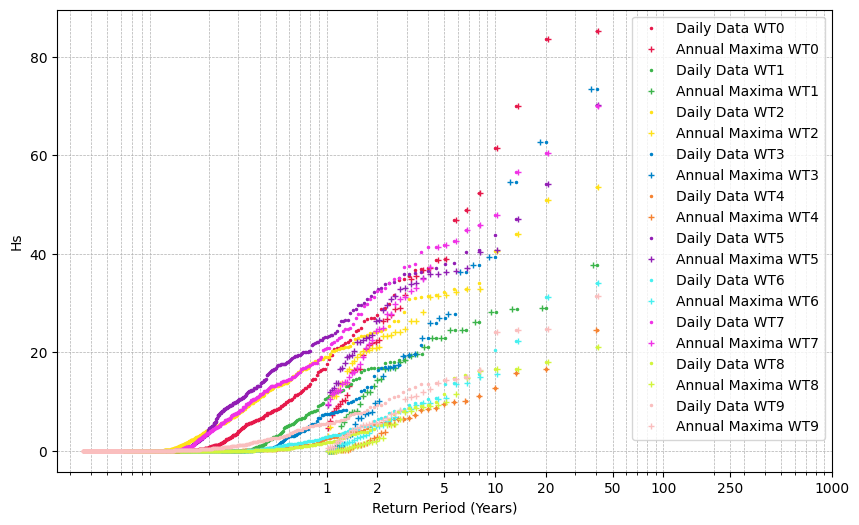

In [12]:
colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4',
    '#46f0f0', '#f032e6', '#d2f53c', '#fabebe', '#008080', '#e6beff',
    '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
    '#000080', '#808080', '#ffffff', '#000000', '#ff0000', '#00ff00',
    '#0000ff', '#ffff00', '#ff00ff', '#00ffff', '#800080', '#ff4500',
    '#8b0000', '#008000', '#4682b4', '#d2691e', '#ff1493', '#6495ed'
]


fig = plt.figure(figsize=(10,6))
ax= fig.add_subplot()
for idx_wt in range(10):
    ax.semilogx(T_pt[idx_wt], hspt_sort[idx_wt], linewidth=0, color=colors[idx_wt], marker='o',markersize=1.5, label=f'Daily Data WT{idx_wt}')
    ax.semilogx(T_ev_wt[idx_wt], hsmax_data_sorted[idx_wt], color=colors[idx_wt], linewidth=0, marker='+',markersize=5, label=f'Annual Maxima WT{idx_wt}')

# Configurar escala logarítmica y ticks personalizados
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Mantiene los números sin notación científica

# Etiquetas y grid
ax.set_xlabel('Return Period (Years)')
ax.set_ylabel('Hs')
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Mostrar gráfico
plt.legend()
plt.show()

# Corrección Extremos en Bloques usando la clase ya creada

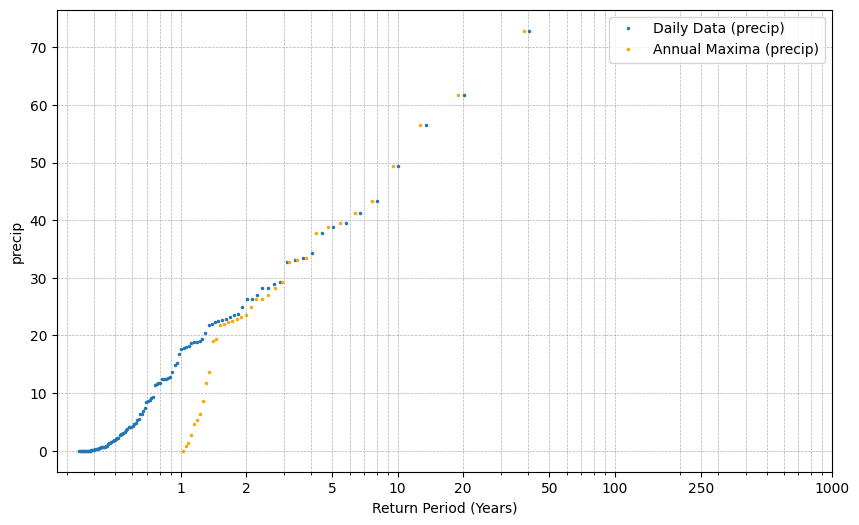

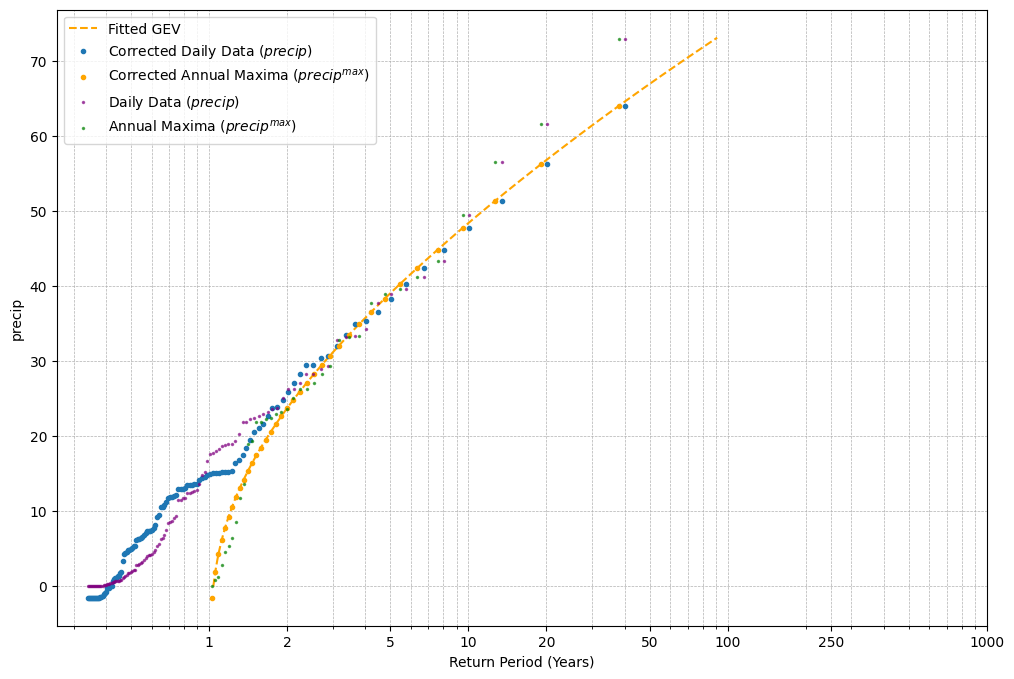

In [13]:
from ExtremePOT_Correction.extremecorrection import ExtremeCorrection

# for idx_wt, wt in enumerate(wt_range):
idx_wt=35
extremecorr = ExtremeCorrection(dict_hs[idx_wt], data_var='precip', frequency=n_return_period[idx_wt])
extremecorr.return_period_plot()

output_dir = "Figuras/Precip/CorrectionMax_WT_Precip"
os.makedirs(output_dir, exist_ok=True)

fig = extremecorr.return_period_plot_corrected(without_corr=True)  # Generar gráfico

fig.savefig(f"{output_dir}/ReturnPeriod_WT{idx_wt}.png", dpi=200, bbox_inches='tight')
# extremecorr.plot_ts()

# Ajuste de Pareto-Poisson a cada WT

## Selección del threshold óptimo

In [14]:
from OptimalThresholdSelection.optimal_threshold_studentized import OptimalThreshold

### Selección del umbral óptimo para los datos completos sin división por WT

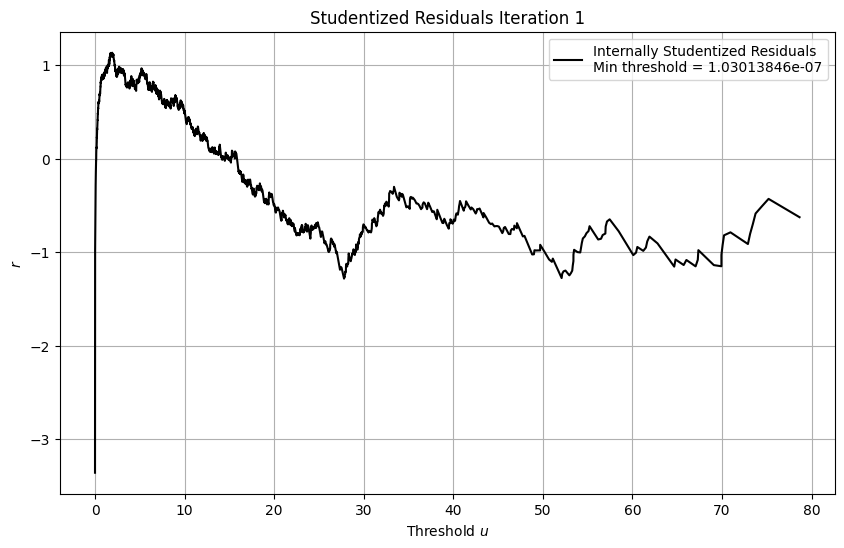

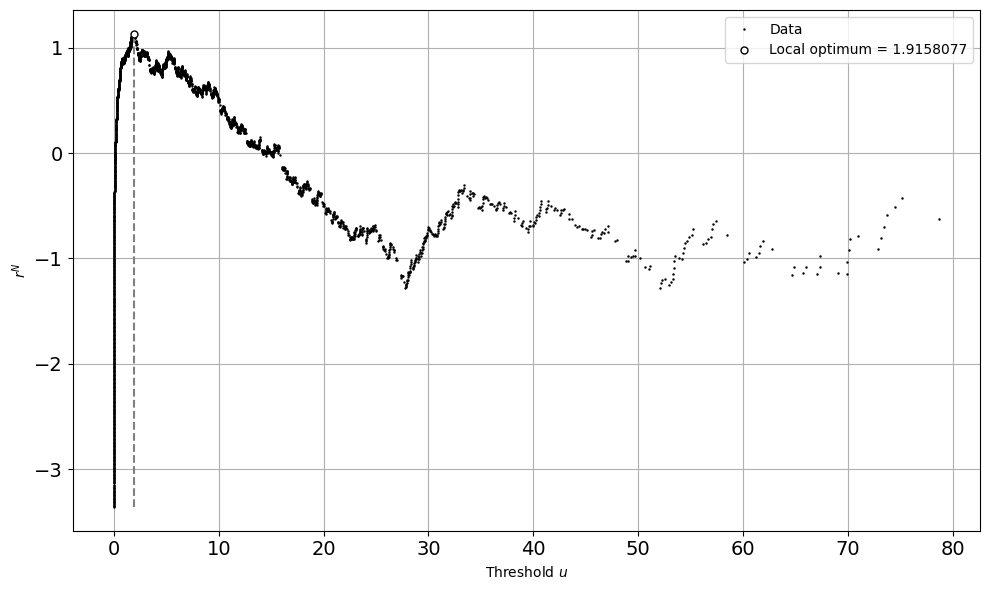

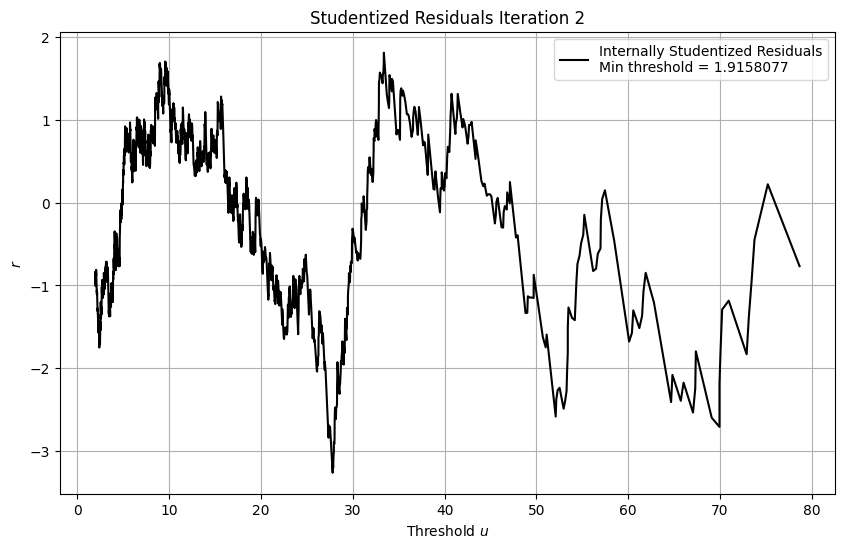

[1.9158077]


In [15]:
threshold = 0.0
n0 = 10
min_peak_distance = 2   # 2 días de distancia entre picos
siglevel=0.05

# Inicializar la clase
opt_thres = OptimalThreshold(data=df_prec['precip'].values)
# Obtener los picos
opt_thres.threshold_peak_extraction(threshold=0,
                                    n0=n0,
                                    min_peak_distance=min_peak_distance)

# Crear carpeta si no existe
folder_path = "Figuras/Precip/"
os.makedirs(folder_path, exist_ok=True)

# Obtener el threshold óptimo
threshold = opt_thres.threshold_studentized_residuals(siglevel=siglevel,
                                                      plot_flag=True,
                                                      filename=f"{folder_path}Precip",
                                                      display_flag=False)
print(threshold)

### Selección del threshold óptimo para cada WT

Primero dividimos los datos por WT y le asignamos el valor 0 a los datos en los que no aparezca ese WT

In [16]:
df_rwt = df_prec.copy()

# Obtener valores únicos de RWT
unique_rwt = df_prec['LWT'].unique()

# Crear nuevas columnas Hs_RWT0, Hs_RWT1, ..., Hs_RWTn
for wt in unique_rwt:
    df_rwt[f'P_LWT{int(wt)}'] = df_prec['precip'].where(df_prec['LWT'] == wt, 0)

#### Obtenemos el threshold óptimo para cada WT usando la clase creada

In [17]:
# Por si se quiere usar quantiles para determinar el threshold optimo
quantiles_998 = np.zeros(len(wt_range))
for wt in unique_rwt:
    quantiles_998[wt] = np.quantile(df_rwt[f'P_LWT{int(wt)}'].values, 0.998)

In [18]:
thresholds = np.zeros(len(wt_range))
thresholds[[16,30]] = quantiles_998[[16,30]]    # Modificación de algun threshold por si hay demasiados ceros en la precipitación
thresholds[[16,30]] = [0.5,0.7]    # Modificación de algun threshold por si hay demasiados ceros en la precipitación
picos = {}
pks = {}
n0 = 10
min_peak_distance = 2   # 2 días de distancia entre picos
siglevel = 0.05         # Nivel de confianza

for wt in unique_rwt[:]:
    # Inicializar la clase
    opt_thres = OptimalThreshold(data=df_rwt[f'P_LWT{int(wt)}'].values)
    # Obtener los picos
    opt_thres.threshold_peak_extraction(threshold=thresholds[wt],
                                        n0=n0,
                                        min_peak_distance=min_peak_distance)
    
    #picos[wt] = opt_thres.pks_unicos_valid
    picos[wt] = np.sort(opt_thres.pks)
    # Obtener el threshold óptimo
    thresholds[wt] = opt_thres.threshold_studentized_residuals(siglevel=siglevel).item()

In [19]:
thresholds[[16,30]]

array([3.121044  , 0.70191795])

In [20]:
### CAMBIAR ESTO Y VER DONDE FALLA LA FUNCIÓN DE THRESHOLD SELECTION!!!
# for thres_idx, threshold in enumerate(thresholds):
#     if threshold < 1e-6:
#         thresholds[thres_idx] = 1

In [21]:
poisson_parameter = np.zeros(len(wt_range))
for wt in unique_rwt[:]:
    poisson_parameter[wt] = len(picos[wt][picos[wt]>thresholds[wt]])/40

In [22]:
poisson_parameter

array([3.375, 1.8  , 4.275, 1.85 , 1.325, 5.05 , 2.025, 5.325, 1.45 ,
       3.075, 1.   , 5.575, 1.775, 2.325, 2.775, 2.925, 0.525, 0.75 ,
       1.85 , 3.   , 2.375, 6.225, 3.225, 4.   , 1.5  , 4.425, 4.3  ,
       1.2  , 0.875, 6.075, 0.8  , 3.   , 0.35 , 0.85 , 1.025, 1.425])

#### Ajuste de Pareto para cada WT

In [23]:
from scipy.stats import genpareto

In [24]:
xi = np.zeros(len(wt_range))
loc = np.zeros(len(wt_range))
sigma = np.zeros(len(wt_range))

for wt in unique_rwt[:]:
    xi[wt], loc[wt], sigma[wt] = genpareto.fit(picos[wt][picos[wt]>thresholds[wt]]-thresholds[wt], floc=0)

In [25]:
folder_path = "Figuras/Precip/QQPlots"
os.makedirs(folder_path, exist_ok=True)

for wt in unique_rwt[:]:
    # Ajustar la GPD con threshold fijo
    shape, loc, scale = genpareto.fit(picos[wt][picos[wt] > thresholds[wt]], floc=thresholds[wt])

    # Calcular cuantiles teóricos de la GPD ajustada
    n = len(picos[wt][picos[wt] > thresholds[wt]])
    probabilities = (np.arange(1, n + 1) - 0.5) / n  # Probabilidades de los cuantiles empíricos
    gpd_quantiles = genpareto.ppf(probabilities, shape, loc=loc, scale=scale)

    # Ordenar los datos observados para comparación con los cuantiles teóricos
    sorted_data = np.sort(picos[wt][picos[wt] > thresholds[wt]])

    # Crear el QQ-plot
    plt.figure(figsize=(7, 7))
    plt.scatter(gpd_quantiles, sorted_data, label="Datos vs. GPD", alpha=0.7)
    plt.plot(gpd_quantiles, gpd_quantiles, 'r--', label="y = x (Referencia)")

    # Etiquetas
    plt.xlabel("Cuantiles Teóricos (GPD ajustada)")
    plt.ylabel("Cuantiles Empíricos (Datos)")
    plt.title("QQ-plot: Ajuste de la GPD a los Datos")
    plt.legend()
    plt.grid()
    plt.savefig(f"{folder_path}/QQPlot_{wt}.png", dpi=200)
    plt.close()

### Corrección Extremal para cada WT

In [26]:
def qgpd(prob,threshold,xi,sigma):
    return genpareto.ppf(prob, c=xi, loc=threshold, scale=sigma)

In [27]:
# Defining dictionary to store all the data for differents WT
ecdf_pot_probs = {}
hs_pot_wt0_corrected = {}
hs_wt0_corrected = {}
ecdf_pot_probs_corrected ={}
T_ev_corrected = {}
ecdf_pt_probs_corrected = {}
T_pt_corrected = {}
x_values_gpd = {}
fitted_return_perd_values_gpd = {}
T_pot = {}
ecdf_pt_probs_wt = {}
T_pt_wt = {}

# Correction loop
for wt in unique_rwt[:]:
    # Probabilidades empíricas de los picos 
    ecdf_pot_probs[wt] = np.arange(1,len(picos[wt][picos[wt]>thresholds[wt]])+1)/(len(picos[wt][picos[wt]>thresholds[wt]])+1)
    # Picos corregidos
    hs_pot_wt0_corrected[wt] = qgpd(ecdf_pot_probs[wt], thresholds[wt], xi[wt], sigma[wt])

    # Corrección de los datos diarios
    hs_wt0_corrected[wt] = dict_hs[wt]['precip'].values.copy()
    for block_idx, max_value in enumerate(picos[wt][picos[wt]>thresholds[wt]]):
        if block_idx >= len(picos[wt][picos[wt]>thresholds[wt]])-1:
            hs_wt0_corrected[wt][dict_hs[wt]['precip'].values >= picos[wt][picos[wt]>thresholds[wt]][-1]] = hs_pot_wt0_corrected[wt][-1]
            break
        else:
            for idx, daily_value in enumerate(dict_hs[wt]['precip'].values):
                if daily_value >= picos[wt][picos[wt]>thresholds[wt]][block_idx] and daily_value < picos[wt][picos[wt]>thresholds[wt]][block_idx+1]:
                    hs_wt0_corrected[wt][idx] = hs_pot_wt0_corrected[wt][block_idx]+((daily_value-picos[wt][picos[wt]>thresholds[wt]][block_idx])/(picos[wt][picos[wt]>thresholds[wt]][block_idx+1]-picos[wt][picos[wt]>thresholds[wt]][block_idx]))*(hs_pot_wt0_corrected[wt][block_idx+1]-hs_pot_wt0_corrected[wt][block_idx])


    # Calculo de probabilidades y periodos de retorno
    x_values_gpd[wt] = np.linspace(picos[wt][picos[wt] >thresholds[wt]][0], picos[wt][picos[wt] >thresholds[wt]][-1], 1000)
    fitted_return_perd_values_gpd[wt] = 1/(1-genpareto.cdf(x_values_gpd[wt], c=xi[wt], loc=thresholds[wt], scale=sigma[wt]))/poisson_parameter[wt]

    ecdf_pot_probs_corrected[wt] = genpareto.cdf(qgpd(ecdf_pot_probs[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), c=xi[wt], loc=thresholds[wt], scale=sigma[wt])
    T_ev_corrected[wt] = 1/(1-ecdf_pot_probs_corrected[wt])/poisson_parameter[wt]   # Se divide entre el nºmedio de POTs ocurrencias por WT 

    ecdf_pt_probs_corrected[wt] = np.arange(1,len(hs_wt0_corrected[wt])+1)/(len(hs_wt0_corrected[wt])+1)
    T_pt_corrected[wt] = 1/(1-ecdf_pt_probs_corrected[wt])/n_return_period[wt]      # Se divide entre la probabilidad de ocurrencia de ese WT
    
    # POT sin corregir
    T_pot[wt] = 1/(1-ecdf_pot_probs[wt])/poisson_parameter[wt]      # Se divide entre el nºmedio de ocurrencias de ese POT por WT 

    # Daily data sin corregir
    ecdf_pt_probs_wt[wt] = np.arange(1,len(dict_hs[wt]['precip'].values)+1)/(len(dict_hs[wt]['precip'].values)+1)
    T_pt_wt[wt] = 1/(1-ecdf_pt_probs_wt[wt])/n_return_period[wt]    # Se divide entre la probabilidad de ocurrencia de ese WT

In [28]:
weather_type = 0
# Gráfico
for weather_type in unique_rwt[:]:
    fig = plt.figure(figsize=(12,8))
    ax= fig.add_subplot()
    ax.semilogx(fitted_return_perd_values_gpd[weather_type], np.sort(x_values_gpd[weather_type]), color = 'orange',linestyle='dashed', label='Fitted GPD')
    ax.semilogx(T_pt_corrected[weather_type], np.sort(hs_wt0_corrected[weather_type]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($P$)')
    ax.semilogx(T_ev_corrected[weather_type], qgpd(ecdf_pot_probs[weather_type], xi=xi[weather_type], threshold=thresholds[weather_type], sigma=sigma[weather_type]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($P$)')

    # Si representamos los datos sin corregir
    ax.semilogx(T_pot[weather_type], picos[weather_type][picos[weather_type] > thresholds[weather_type]], color="green", linewidth=0, marker='+',markersize=3, label='POT')
    ax.semilogx(T_pt_wt[weather_type], np.sort(dict_hs[weather_type]['precip'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')


    ax.set_xlabel("Return Periods (Years)")
    ax.set_ylabel("Precipitation")
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.legend()
    ax.grid()
    plt.savefig(f"Figuras/Precip/CorrectionPOT_WT_Precip/ReturnPeriod_{weather_type}.png", dpi=300)
    plt.close()

## Máximos anuales corregidos con Pareto-Poisson

In [54]:
def q_pareto_poisson(probs, threshold, xi, sigma, lam, wt):
    """
    Calculates the quantiles of POT 
    """
    # Gumbel case
    if np.abs(xi[wt]) < 1e-8:
        out = threshold[wt] - sigma[wt]*np.log(np.log(probs)/lam[wt])
    # General case
    else:
        out = threshold[wt] - sigma[wt]/xi[wt]*(1-(-np.log(probs)/lam[wt])**(-xi[wt]))
    return out

def dq_pot(probs, threshold, xi, sigma, lam, wt):
    """
    Calculates the dertivative of quantiles of POT
    """
    Dq = np.zeros((3,len(probs)))
    # Gumbel case
    if np.abs(xi[wt]) < 1e-8:
        Dqlam = sigma[wt]/lam[wt]
        Dqsigma = -np.log(-np.log(probs)/lam[wt])
        Dqxi = np.zeros(len(probs))
    # General case
    else:
        Dqlam = sigma[wt]/lam[wt]*(-np.log(probs)/lam[wt])**(-xi[wt])
        Dqsigma = -(1-(-np.log(probs)/lam[wt])**(-xi[wt]))/xi[wt]
        Dqxi = sigma[wt]*(1-(-np.log(probs)/lam[wt])**(-xi[wt])*(1+xi[wt]*np.log(-np.log(probs)/lam[wt])))/(xi[wt]*xi[wt])

    Dq[0,:] = Dqlam
    Dq[1,:] = Dqsigma*sigma[wt]
    Dq[2,:] = Dqxi

    return Dq


def loglikelihood(x, u, Ts, xi, sigma, lam, wt):
    """
    Calcula el log-likelihood, su gradiente (Jacobian) y la matriz Hessiana
    para el modelo Pareto-Poisson.

    Parámetros:
      p  : vector de parámetros. p[0] es la localización (lambda),
           p[1] es el parámetro que se transforma a escala mediante exp(p[1]),
           p[2] (opcional) es el parámetro de forma.
      x  : datos (vector numpy).
      u  : umbral.
      Ts : total (por ejemplo, tiempo total o número de días) para el componente Poisson.

    Retorna:
      f   : valor del log-likelihood (negativo de la función objetivo)
      Jx  : gradiente (vector de tamaño 2 o 3, dependiendo de p)
      Hxx : Hessiana (matriz de tamaño 2x2 o 3x3)
    """
    N = len(x)
    
    # Parámetro de localización (lambda) es un escalar
    lambt = lam[wt]
    # Escala: se calcula a partir de exp(p[1]) y se extiende a todos los datos
    sigt = sigma[wt] * np.ones_like(x)
    
    # Parámetro de forma: si p tiene 3 elementos se utiliza, sino se asume cero
    if np.abs(xi[wt]) > 1e-8:
        neps0 = 1
        epst = xi[wt] * np.ones_like(x)
    else:
        neps0 = 0
        epst = np.zeros_like(x)
    
    # Se determinan los índices donde el parámetro de forma es prácticamente cero (caso Gumbel)
    posG = np.where(np.abs(epst) <= 1e-8)[0]
    pos  = np.where(np.abs(epst) > 1e-8)[0]
    
    # Para evitar problemas numéricos, en las posiciones Gumbel se iguala epst a 1
    epst_mod = epst.copy()
    epst_mod[posG] = 1.0
    
    # Cálculo de variables intermedias
    Yt = x - u            # excesos respecto al umbral
    xn = Yt / sigt        # variable adimensional
    z = 1 + epst_mod * xn
    # Se asegura que z tenga un valor mínimo (para evitar log(0))
    z = np.maximum(1e-8, z)
    
    # Cálculo del log-likelihood
    # Para las observaciones en pos (Weibull/Fréchet) y para posG (Gumbel)
    term_pos = np.sum(-np.log(sigt[pos]) - (1 + 1/epst_mod[pos]) * np.log(z[pos])) if pos.size > 0 else 0.0
    term_posG = np.sum(-np.log(sigt[posG]) - xn[posG]) if posG.size > 0 else 0.0

    f = N * np.log(lambt) - Ts * lambt + term_pos + term_posG
    f = -f   # Loglikelihood  
    
    # Cálculo del gradiente (Jacobian)
    # Derivada con respecto a lambda (localización)
    Dlambt = N / lambt - Ts  # escalar
    # Derivada respecto a la escala
    Dsigt = -(1 - xn) / (sigt * z)
    # Derivada respecto al parámetro de forma
    Depst = (-1 - epst_mod + (1 + epst_mod)/z + np.log(z)) / (epst_mod**2)
    
    # Para los casos Gumbel se ajustan las derivadas:
    if posG.size > 0:
        Dsigt[posG] = -(1 - xn[posG]) / sigt[posG]
        Depst[posG] = 0.0
    
    # Se construye el vector Jacobiano (dimensión 2 o 3)
    Jx = np.zeros(2 + neps0)
    Jx[0] = Dlambt  # (escalar)
    Jx[1] = np.sum(Dsigt * sigt)  # se multiplica por sigt y se suma sobre todas las observaciones
    if neps0 == 1:
        Jx[2] = np.sum(Depst)
    Jx = -Jx  # se retorna el negativo
    
    # Cálculo de la Hessiana
    # Segunda derivada respecto a lambda:
    D2lambt = -1 / (lambt**2)  # escalar
    # Segunda derivada respecto a sigma (escala)
    D2sigt = (-1 + (1 + epst_mod) / (z**2)) / (sigt**2 * epst_mod)
    # Segunda derivada respecto al parámetro de forma
    D2epst = (xn * (2 + epst_mod*(3 + epst_mod)*xn)) / ((epst_mod * z)**2) - 2 * np.log(z) / (epst_mod**3)
    # Derivadas cruzadas (se inicializan en cero)
    Dlambtsigt = np.zeros_like(z)
    Dlambtepst = np.zeros_like(z)
    Dsigtepst = (xn * (1 - xn)) / (sigt * z**2)
    
    # Ajuste de las derivadas en el caso Gumbel
    if posG.size > 0:
        D2sigt[posG] = (1 - 2 * xn[posG]) / (sigt[posG]**2)
        D2epst[posG] = 0.0
        Dlambtsigt[posG] = 0.0
        Dlambtepst[posG] = 0.0
        Dsigtepst[posG] = 0.0
    
    # Se arma la matriz Hessiana, de dimensión (2+neps0) x (2+neps0)
    Hxx = np.zeros((2 + neps0, 2 + neps0))
    # Elemento (1,1): en Matlab se suma sobre todas las observaciones.
    # Dado que lambt es escalar, (D2lambt * lambt * lambt) es constante y se multiplica por N.
    Hxx[0, 0] = np.sum(D2lambt * lambt * lambt)  # equivale a -N
    # Elemento (2,2):
    Hxx[1, 1] = np.sum((D2sigt * sigt + Dsigt) * sigt)
    # Elemento (3,3) si se estima el parámetro de forma
    if neps0 == 1:
        Hxx[2, 2] = np.sum(D2epst)
    
    # Derivadas cruzadas:
    # Elemento (2,1)
    Hxx[1, 0] = np.sum(Dlambtsigt * sigt * lambt)
    if neps0 == 1:
        # Elemento (3,1)
        Hxx[2, 0] = np.sum(Dlambtepst * lambt)
        # Elemento (3,2)
        Hxx[2, 1] = np.sum(Dsigtepst * sigt)
    
    # Se completa la simetrización (se suma la parte triangular inferior transpuesta)
    Hxx = Hxx + np.tril(Hxx, -1).T
    Hxx = -Hxx  # se retorna el negativo
    
    return f, Jx, Hxx


In [ ]:
from scipy import stats 

quanval=0.95

# Defining dictionaries
new_max_idx = {}
annual_maxima_corrected = {}
annual_maxima_corrected_sorted = {}
ecdf_annual_maxima = {}
T_ecdf_annual_maxima = {}
adjusted_quantiles_for_maxima = {}
dq = {}
hessians = {} 
invI0 = {} 
stdDq = {}
stdup = {}
stdlo = {}

for wt in unique_rwt[:]:
    # Indices para los máximos corregidos
    new_max_idx[wt] = dict_hs[wt]['precip'].index.get_indexer(max_idx[wt])

    annual_maxima_corrected[wt] = hs_wt0_corrected[wt][new_max_idx[wt]]
    annual_maxima_corrected_sorted[wt] = np.sort(annual_maxima_corrected[wt])
    
    # Empirical probability and Return periods for the empirical 
    ecdf_annual_maxima[wt] = np.arange(1,len(annual_maxima_corrected_sorted[wt])+1)/(len(annual_maxima_corrected_sorted[wt])+1)
    T_ecdf_annual_maxima[wt] = 1/(1-ecdf_annual_maxima[wt])*(40/len(annual_maxima_corrected[wt]))   # Se divide por la proporción de años en los que aparece ese WT (nºde años que aparece / nºaños registro)
    
    # Adjusted probability
    # Usamos la probabilidad en base a los periodos de retorno por si no aparece el WT el mismo numero de años que el registro
    adjusted_quantiles_for_maxima[wt] = q_pareto_poisson(1-1/T_ecdf_annual_maxima[wt], threshold=thresholds, xi=xi, sigma=sigma, lam=poisson_parameter, wt=wt)  
    
    # Confidence Intervals
    dq[wt] = dq_pot(ecdf_annual_maxima[wt], threshold=thresholds, xi=xi, sigma=sigma, lam=poisson_parameter, wt=wt)
    _,_, hessians[wt] = loglikelihood(picos[wt][picos[wt] > thresholds[wt]], thresholds[wt], 365.25*40, xi, sigma, poisson_parameter, wt)
    invI0[wt] = np.linalg.inv(hessians[wt])
    
    stdDq[wt] = np.sqrt(np.sum((dq[wt].T@invI0[wt]) * dq[wt].T, axis=1)) # Es lo mismo 
    stdup[wt] = adjusted_quantiles_for_maxima[wt] + stdDq[wt]*stats.norm.ppf(1-(1-quanval)/2,0,1)
    stdlo[wt] = adjusted_quantiles_for_maxima[wt] - stdDq[wt]*stats.norm.ppf(1-(1-quanval)/2,0,1)

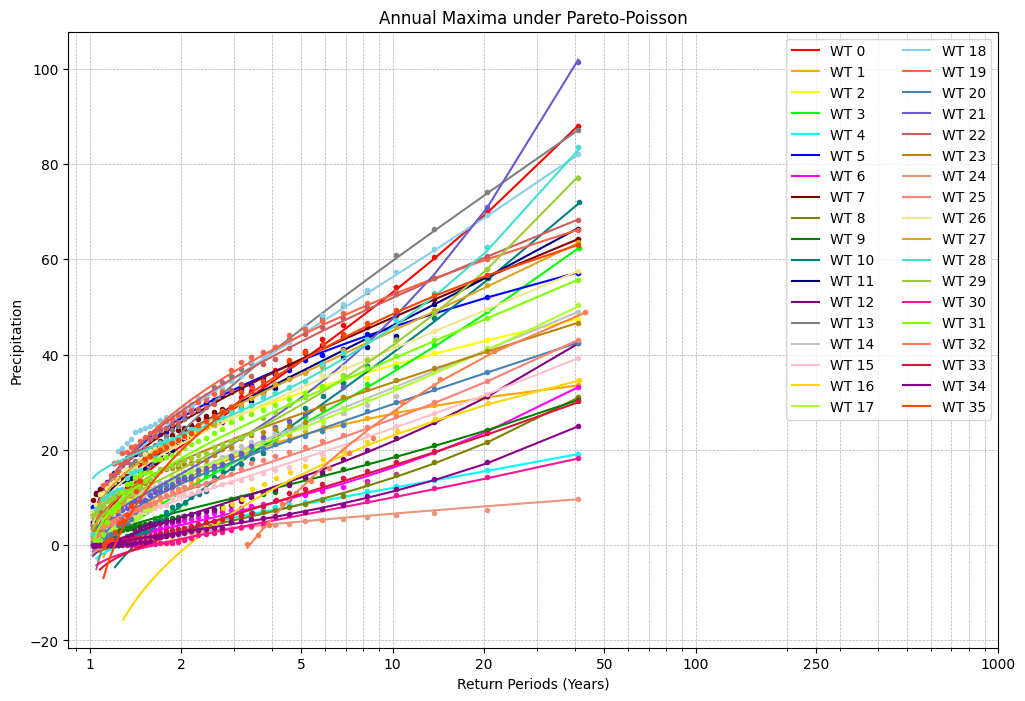

In [89]:
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()

colors = [
    "#FF0000", "#FFA500", "#FFFF00", "#00FF00", "#00FFFF", "#0000FF", "#FF00FF", "#800000", 
    "#808000", "#008000", "#008080", "#000080", "#800080", "#808080", "#C0C0C0", "#FFC0CB", 
    "#FFD700", "#ADFF2F", "#87CEEB", "#FF6347", "#4682B4", "#6A5ACD", "#CD5C5C", "#B8860B", 
    "#E9967A", "#FA8072", "#F0E68C", "#DAA520", "#40E0D0", "#9ACD32", "#FF1493", "#7FFF00", 
    "#FF7F50", "#DC143C", "#8B008B", "#FF4500"
    ]
for wt in np.sort(unique_rwt[:]):
    ax.semilogx(T_ecdf_annual_maxima[wt], annual_maxima_corrected_sorted[wt], color = colors[wt], linewidth=0, marker='o',markersize=3)
    ax.semilogx(T_ecdf_annual_maxima[wt], adjusted_quantiles_for_maxima[wt], color = colors[wt], label=f'WT {wt}')


ax.set_xlabel("Return Periods (Years)")
ax.set_ylabel("Precipitation")
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.legend(ncol=2)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.set_title("Annual Maxima under Pareto-Poisson")
plt.savefig(f"Figuras/Precip/AnnMax_ReturnPeriod_All_Precip.png", dpi=300)
plt.show()

#### Graficos completos

In [90]:
folder_path = "Figuras/Precip/CompleteReturnPeriods_Precip"
os.makedirs(folder_path, exist_ok=True)

for wt in np.sort(unique_rwt[:]):
    
    fig = plt.figure(figsize=(12,8))
    ax= fig.add_subplot()   

    ax.semilogx(fitted_return_perd_values_gpd[wt], np.sort(x_values_gpd[wt]), color = 'orange',linestyle='dashed', label='Adjusted GPD')
    ax.semilogx(T_pt_corrected[wt], np.sort(hs_wt0_corrected[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($P$)')
    ax.semilogx(T_ev_corrected[wt], qgpd(ecdf_pot_probs[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($P$)')

    # Si representamos los datos sin corregir
    # ax.semilogx(T_pot[wt], picos[wt][picos[wt] > thresholds[wt]], color="green", linewidth=0, marker='+',markersize=3, label='POT')
    # ax.semilogx(T_pt_wt[wt], np.sort(dict_hs[wt]['Hs'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

    # Annual Return Periods
    # Adjust the return period of corrected data (if annual maxima does not appear all the record)
    ax.semilogx(T_ecdf_annual_maxima[wt], annual_maxima_corrected_sorted[wt], color = "#FF0000", linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
    ax.semilogx(T_ecdf_annual_maxima[wt], adjusted_quantiles_for_maxima[wt], color = "#FF0000",linestyle='dashed', label=f'Adjusted GPD-Poisson')
    
    # Confidence intervals
    ax.semilogx(T_ecdf_annual_maxima[wt], stdup[wt], color = "gray",linestyle='dotted', label=f'{quanval} Conf Int')
    ax.semilogx(T_ecdf_annual_maxima[wt], stdlo[wt], color = "gray",linestyle='dotted')


    ax.set_xlabel("Return Periods (Years)")
    ax.set_ylabel("Precipitation")
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.legend(ncol=2)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ax.set_title("Annual Maxima under Pareto-Poisson")
    ax.set_ylim(-10, np.max(adjusted_quantiles_for_maxima[wt])+10)
    plt.savefig(f"{folder_path}/ReturnPeriod_{wt}.png", dpi=300)
    plt.close()
    # plt.show()

# Serie Simulada

# Ajuste extremal con covariables

In [ ]:
annual_max_idx = df_hs.groupby(["yyyy", "RWT"])["Hs"].idxmax().values
# annual_max_idx = df_hs.groupby(["yyyy"])["Hs"].idxmax().values

PC_list = []
for i in range(100):
    PC_list.append(f"PC{i}")

In [ ]:
from Daily_Hs_StormSurge_ScipyJax.non_stationary_model import NonStationaryModel
import jax.numpy as jnp
import time

xt = df_hs.loc[annual_max_idx,'Hs'].values
t = df_hs.loc[annual_max_idx,'time'].values

# 1. Definición de los datos
xt=jnp.array(xt)
t =jnp.array(t)

# Parámetros iniciales
n_harmonics_loc = 1     # Número de armónicos para ubicación
n_harmonics_scale = 1   # Número de armónicos para escala
n_harmonics_shape = 1   # Número de armónicos para forma
betaT = 0               # Tendencia en localización
betaT2 = 0              # Tendencia en escala
# rhocoeff = 6000  # Coeficiente de penalización Lasso

model_lasso2 = NonStationaryModel(
    xt=xt,
    t=t,
    covariates_loc=jnp.asarray(df_hs.loc[annual_max_idx,PC_list].values),
    covariates_sc=jnp.asarray(df_hs.loc[annual_max_idx,PC_list].values),
    covariates_sh=jnp.empty((len(xt),0)),
    n_harmonics_loc=n_harmonics_loc,
    n_harmonics_scale=n_harmonics_scale,
    n_harmonics_shape=n_harmonics_shape,
    betaT=betaT,
    betaT2=betaT2,
    #rhocoeff=rhocoeff,
    regularization_type="lasso",
    example='Monthly Maxima Hs'
)

In [ ]:
print("Ajustando modelo con regularización Lasso...")
# Iniciar el temporizador
start_time = time.time()
result_lasso = model_lasso2.fit(rhocoeff=20, method='lbfgsb', maxiter=1000, linesearch='zoom')  # linesearch='hager-zhang', 'zoom', 'backtracking'
# Detener el temporizador
end_time = time.time()
# Calcular el tiempo transcurrido
elapsed_time = end_time - start_time
print(f"Tiempo de ejecución L-BFGS-B Grid Search con lasso: {elapsed_time:.2f} segundos")
print("Ajuste completado.\n")

# 9. Obtener y mostrar parámetros ajustados para Lasso
print(f"Valor óptimo de verosimilitud: {result_lasso['loglik']}")
print("\nParámetros ajustados con Lasso:")
model_lasso2.summary()

final_parameters = result_lasso['params']

model_lasso2.PPplot()
model_lasso2.QQplot()